In [3]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install prophet

     --------------------------------------- 13.3/13.3 MB 17.2 MB/s eta 0:00:00
     ---------------------------------------- 93.0/93.0 kB ? eta 0:00:00
     ------------------------------------- 822.9/822.9 kB 50.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tbats

     -------------------------------------- 44.0/44.0 kB 535.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime
from datetime import date
import calendar
pd.set_option('display.max_columns', None)

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

import pmdarima as pm

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

from tbats import TBATS, BATS

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('hourly.csv')

In [7]:
df.dtypes

DateTime                   object
Global_active_power       float64
Global_reactive_power     float64
Voltage                   float64
Global_intensity          float64
Sub_metering_1              int64
Sub_metering_2              int64
Sub_metering_3              int64
Global_active_energy      float64
Global_reactive_energy    float64
Active_Energy             float64
dtype: object

In [8]:
df = df[['DateTime', 'Active_Energy']]

In [9]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [10]:
df.set_index('DateTime', inplace=True)

<AxesSubplot:xlabel='DateTime'>

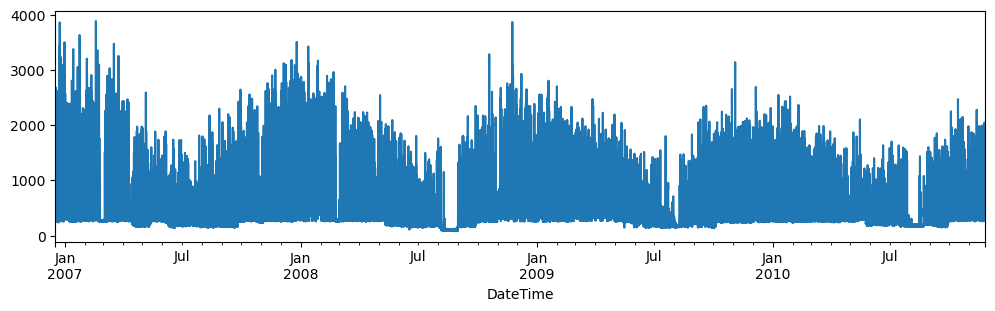

In [11]:
plt.figure(figsize=(12,3), dpi=100)
df.Active_Energy.plot()

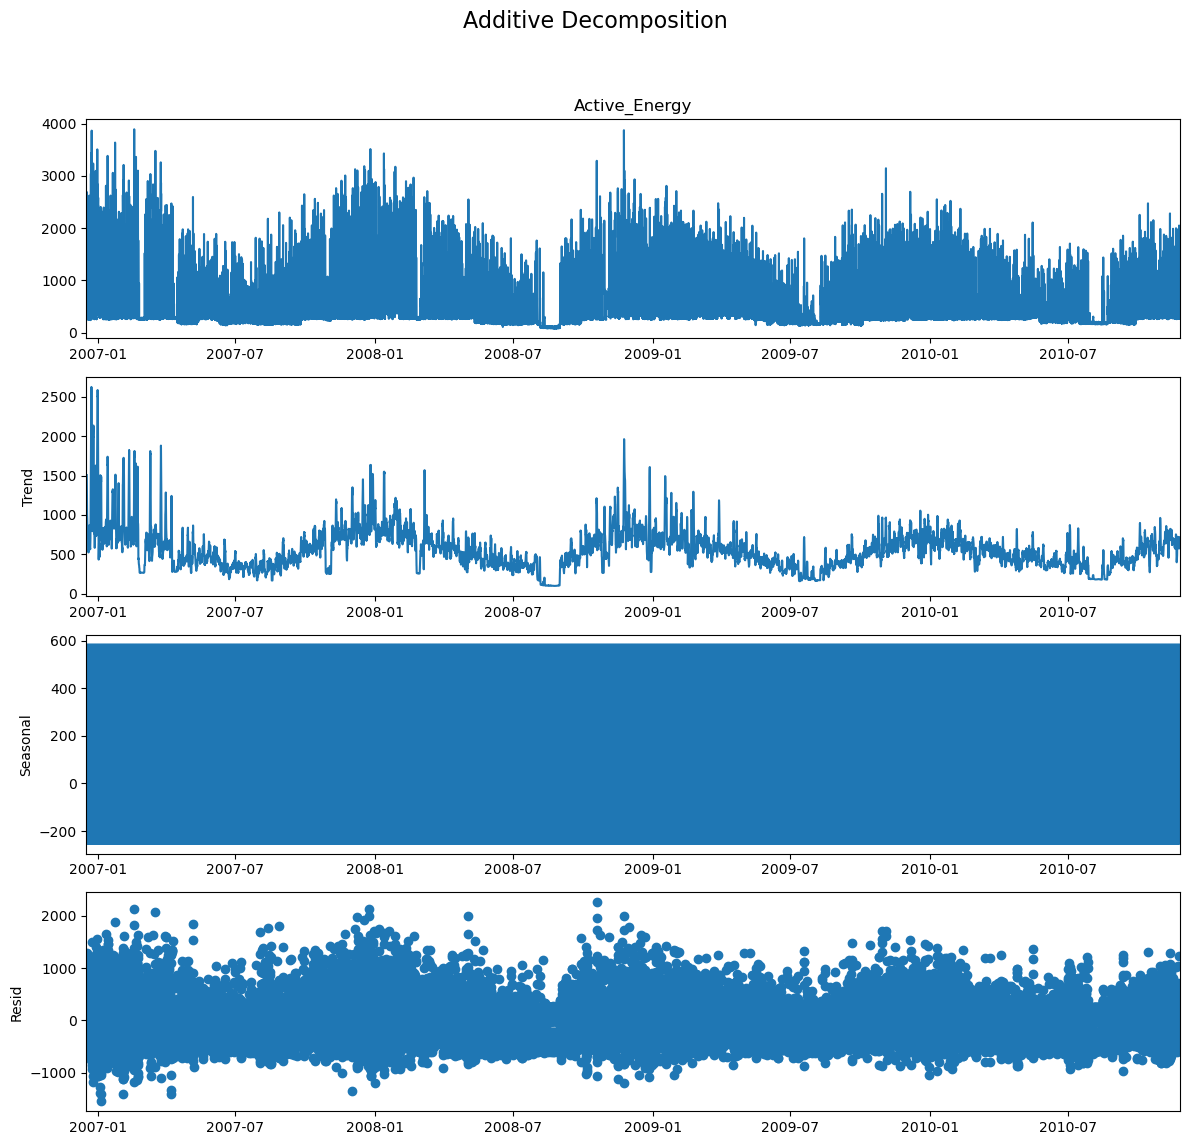

In [12]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['Active_Energy'], model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (12,12)})
multiplicative_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### Train and test

In [13]:
train_df = df[:30000]
test_df = df[30000:]

#### ADF fuller test

In [14]:
#H0: It is non stationary
#H1: It is stationary

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [15]:
adfuller_test(train_df['Active_Energy'])

ADF Test Statistic : -11.761411283855416
p-value : 1.145627798885216e-21
#Lags Used : 49
Number of Observations Used : 29950
strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary


### ACF plots and Differencing

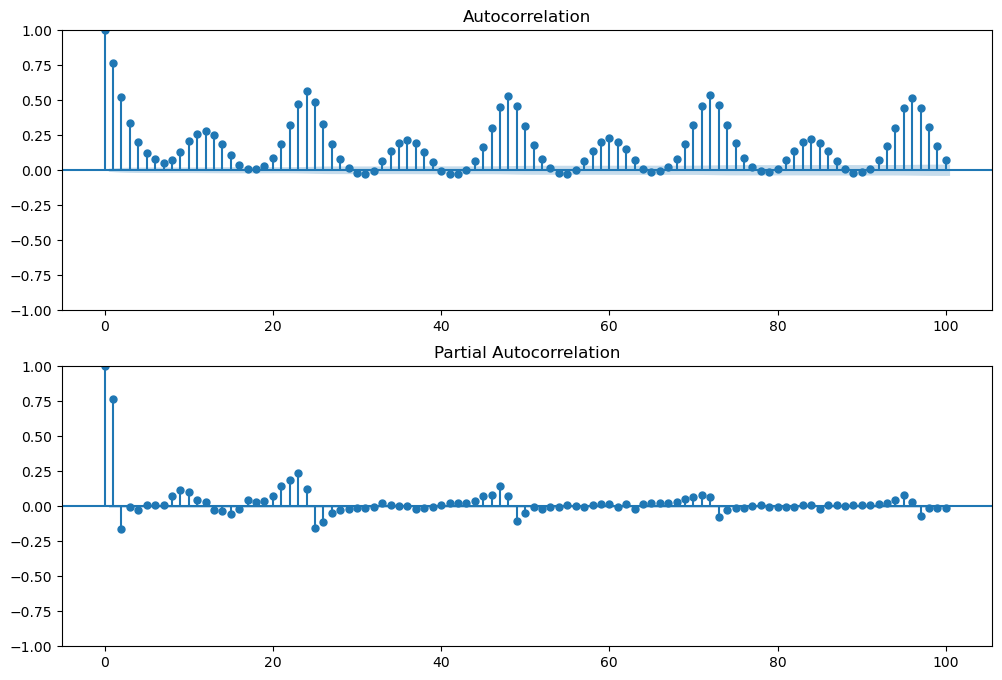

In [16]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(train_df['Active_Energy'], lags=100,ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(train_df['Active_Energy'], lags=100,ax=ax2)

In [17]:
train_df['First Difference'] = train_df['Active_Energy'].diff()

In [18]:
adfuller_test(train_df['First Difference'].dropna())

ADF Test Statistic : -39.19301914901425
p-value : 0.0
#Lags Used : 50
Number of Observations Used : 29948
strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary


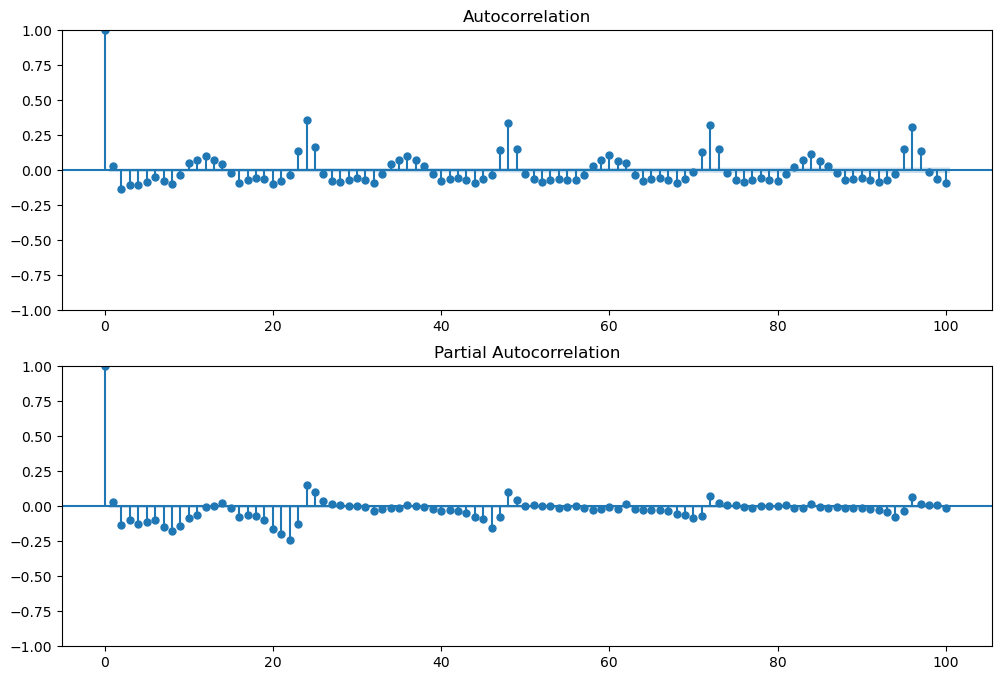

In [19]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(train_df['First Difference'].dropna(),lags=100,ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(train_df['First Difference'].dropna(),lags=100,ax=ax2)

In [20]:
train_df['Seasonal First Difference'] = train_df['Active_Energy'].diff(24)

In [21]:
adfuller_test(train_df['Seasonal First Difference'].dropna())

ADF Test Statistic : -35.599942080073276
p-value : 0.0
#Lags Used : 50
Number of Observations Used : 29925
strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary


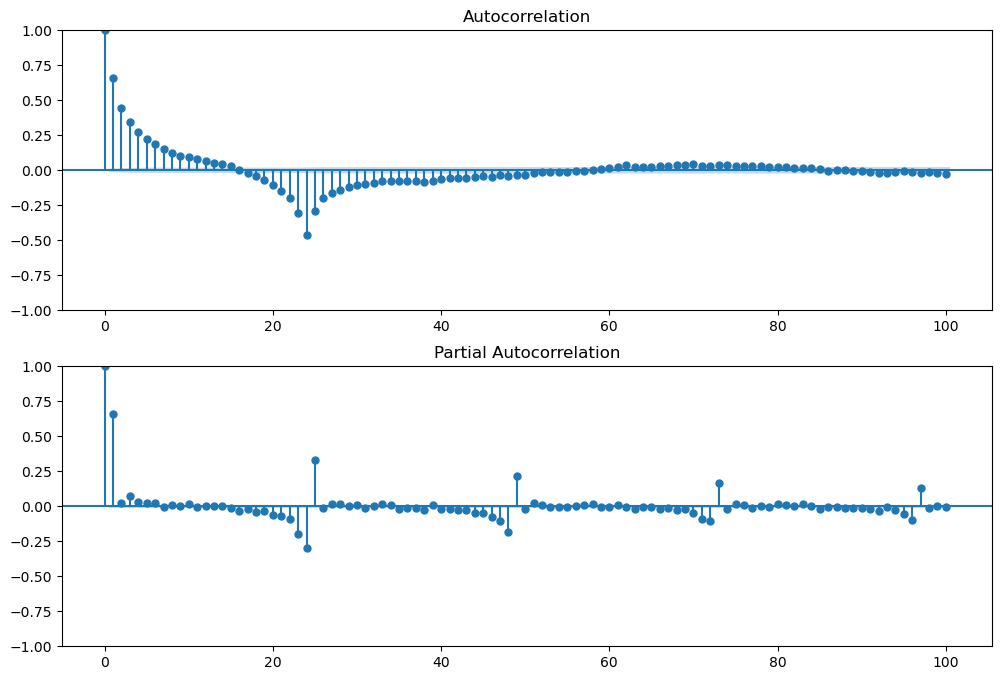

In [22]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(train_df['Seasonal First Difference'].dropna(),lags=100,ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(train_df['Seasonal First Difference'].dropna(),lags=100,ax=ax2)

## General ARIMA

arima_model = ARIMA(train_df['Active_Energy'],order=(2,1,3))

arima_model_fit2 = arima_model.fit()
arima_model_fit2.summary()

In [23]:
## Best AIC model for different p,q values

arima_model = ARIMA(train_df['Active_Energy'],order=(3,1,3))

arima_model_fit2 = arima_model.fit()
print(arima_model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:          Active_Energy   No. Observations:                30000
Model:                 ARIMA(3, 1, 3)   Log Likelihood             -215310.413
Date:                Sat, 18 Nov 2023   AIC                         430634.826
Time:                        23:04:35   BIC                         430692.988
Sample:                    12-17-2006   HQIC                        430653.488
                         - 05-19-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2583      0.020     13.163      0.000       0.220       0.297
ar.L2          0.7816      0.006    121.610      0.000       0.769       0.794
ar.L3         -0.4759      0.014    -34.678      0.0

In [24]:
test_df['arima_no_s_forecast'] = arima_model_fit2.predict(start=30000,end=34560,dynamic=True)

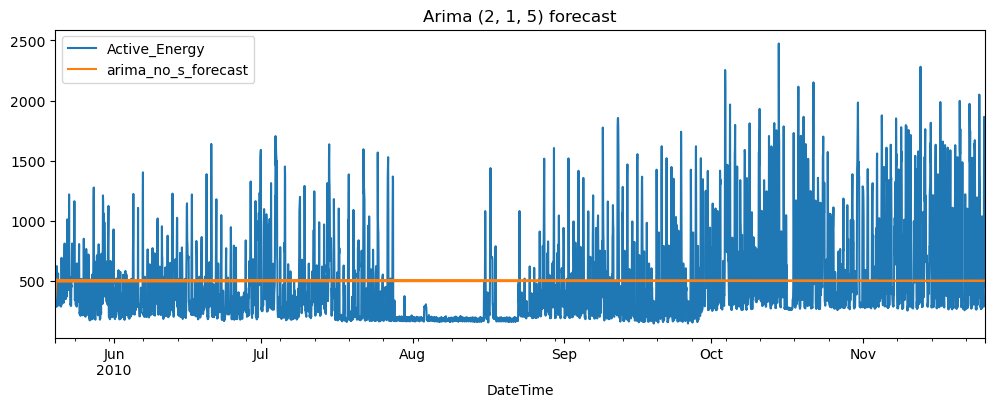

In [25]:
test_df[['Active_Energy','arima_no_s_forecast']].plot(figsize=(12,4))
plt.title('Arima (2, 1, 5) forecast')
plt.show()

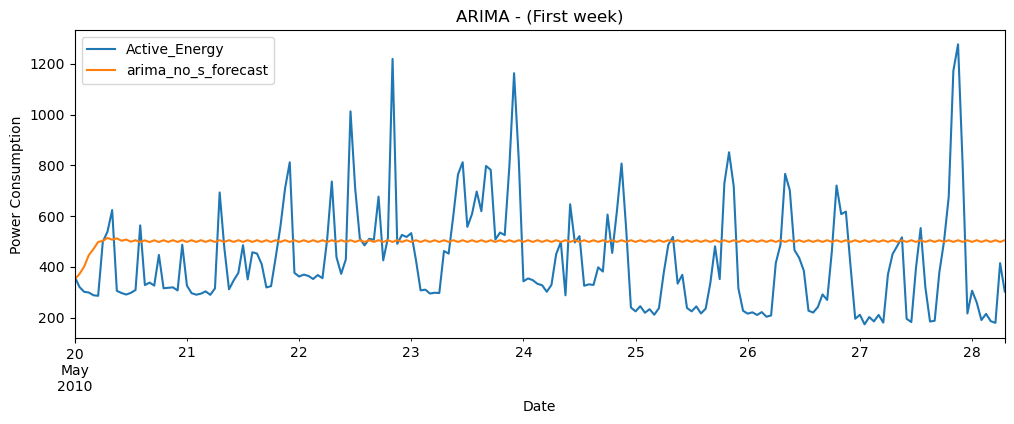

In [26]:
test_df.iloc[:200,[0,1]].plot(figsize=(12,4))

plt.title("ARIMA - (First week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

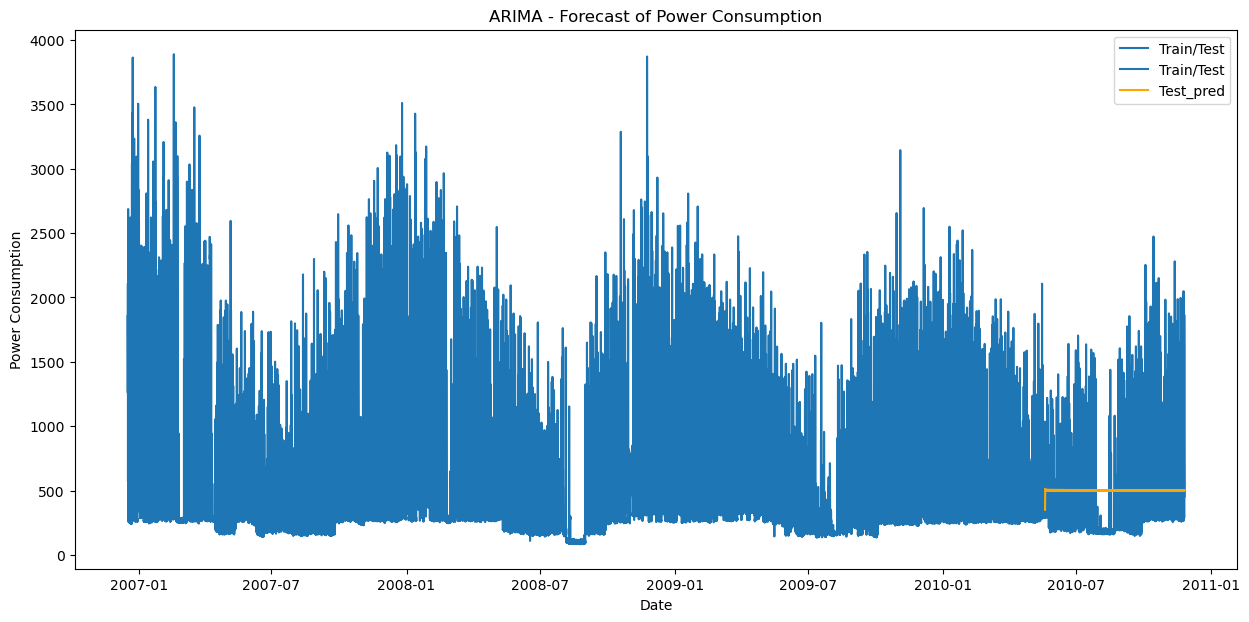

In [27]:
plt.figure(figsize=(15,7))

plt.plot(train_df['Active_Energy'], color='#1f76b4',label='Train/Test')
plt.plot(test_df['Active_Energy'], color='#1f76b4',label='Train/Test')
plt.plot(test_df['arima_no_s_forecast'], color='orange',label='Test_pred')

plt.title("ARIMA - Forecast of Power Consumption")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

In [28]:
rmse_arima = np.sqrt(mean_squared_error(test_df['Active_Energy'], test_df['arima_no_s_forecast']))
r2_arima = r2_score(test_df['Active_Energy'], test_df['arima_no_s_forecast'])
mae_arima = mean_absolute_error(test_df['Active_Energy'], test_df['arima_no_s_forecast'])

print("Root mean Squared Error: ", rmse_arima)
print("R2 Score: ", r2_arima)
print("Mean Absolute Error: ", mae_arima)

Root mean Squared Error:  358.99631827864073
R2 Score:  -0.023914903187277403
Mean Absolute Error:  279.3474265062094


In [78]:
arima_model_fit2.save('arima_model.pkl')

## SARIMA

In [29]:
## p, q, P, Q values from plot

sarima_model = ARIMA(train_df['Active_Energy'], order=(1,1,2), seasonal_order=(1,1,1,24))
sarima_model_fit1 = sarima_model.fit()
sarima_model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Active_Energy   No. Observations:                30000
Model:             ARIMA(1, 1, 2)x(1, 1, [1], 24)   Log Likelihood             -210486.992
Date:                            Sat, 18 Nov 2023   AIC                         420985.984
Time:                                    23:15:57   BIC                         421035.833
Sample:                                12-17-2006   HQIC                        421001.980
                                     - 05-19-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6690      0.004    161.805      0.000       0.661       0.677
ma.L1         -0.9870      0.006   -166.754      0.000      -0.999      -0.975
ma.L2         -0.0129      0.006     -2.187      0.029      -0.025      -0.001
ar.S.L24       0.0531      0.004     12.531      0.000       0.045       0.061
ma.S.L24      -0.9209      0.002   -546.110      0.000      -0.924      -0.918
sigma2      7.321e+04    311.879    234.751      0.000    7.26e+04    7.38e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38441.80
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
## Best AIC model after different trials and iterations

sarima_model = ARIMA(train_df['Active_Energy'], order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_model_fit2 = sarima_model.fit()
print(sarima_model_fit2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                    Active_Energy   No. Observations:                30000
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -210488.131
Date:                          Sun, 19 Nov 2023   AIC                         420986.262
Time:                                  03:35:44   BIC                         421027.803
Sample:                              12-17-2006   HQIC                        420999.592
                                   - 05-19-2010                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6761      0.003    270.302      0.000       0.671       0.681
ma.L1         -1.0000      0.000  -2818.827      0.

In [30]:
test_df['sarima_forecast'] = sarima_model_fit1.predict(start=30000,end=34560,dynamic=True)

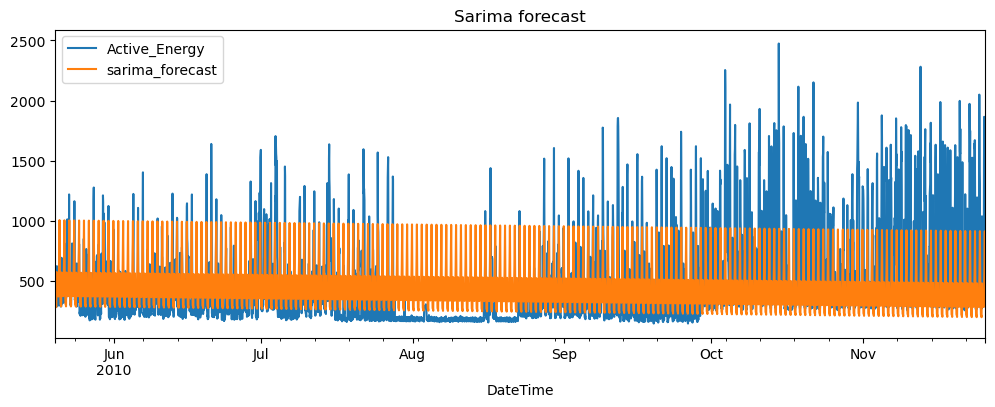

In [31]:
test_df[['Active_Energy','sarima_forecast']].plot(figsize=(12,4))
plt.title('Sarima forecast')
plt.show()

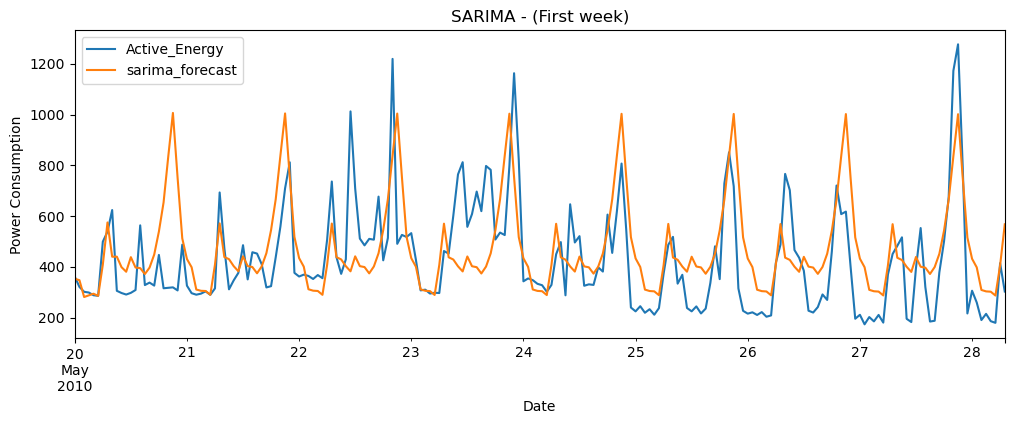

In [32]:
test_df.iloc[:200,[0,2]].plot(figsize=(12,4))

plt.title("SARIMA - (First week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

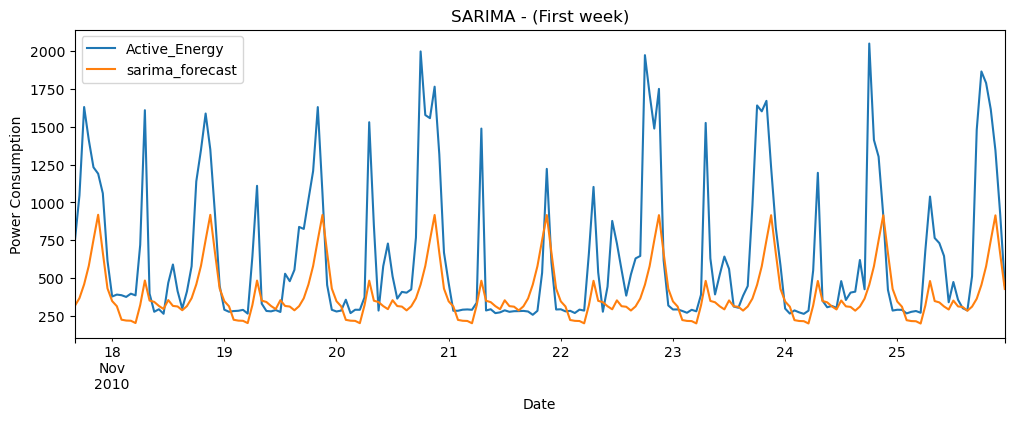

In [33]:
test_df.iloc[-200:,[0,2]].plot(figsize=(12,4))

plt.title("SARIMA - (First week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

In [34]:
rmse_arima = np.sqrt(mean_squared_error(test_df['Active_Energy'], test_df['sarima_forecast']))
r2_arima = r2_score(test_df['Active_Energy'], test_df['sarima_forecast'])
mae_arima = mean_absolute_error(test_df['Active_Energy'], test_df['sarima_forecast'])

print("Root mean Squared Error: ", rmse_arima)
print("R2 Score: ", r2_arima)
print("Mean Absolute Error: ", mae_arima)

Root mean Squared Error:  319.8767514410632
R2 Score:  0.18707734183397418
Mean Absolute Error:  215.5695653358027


In [79]:
sarima_model_fit1.save('sarima_model1.pkl')

## Multiple seasonality

In [ ]:
res = MSTL(df['Active_Energy'], periods=(24,24*365)).fit()
res.plot()
plt.tight_layout()
plt.show()

### TBATS

In [35]:
estimator = TBATS(seasonal_periods=(24, 24*365.25))
model = estimator.fit(train_df['Active_Energy'])

In [36]:
print(model.summary())

Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: [  24. 8766.]
Seasonal harmonics [11  1]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 0.926318
Trend (Beta): -0.221939
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-6.18255204e-08  2.31154993e-07  6.80590811e-08  3.23128522e-07]
AR coefficients []
MA coefficients []
Seed vector [ 7.37011201e+00 -8.40699782e-04  6.22218812e-02 -1.74879478e-01
 -6.42711706e-02  2.38666388e-03 -9.70260243e-02 -1.70659029e-02
  3.67063315e-02  9.76031957e-04 -1.04716147e-02  1.54172810e-02
  5.38842516e-03 -2.81584477e-01 -3.51634669e-01 -1.00207349e-01
  1.12273927e-01  3.30026276e-02 -4.95205146e-02  1.64321312e-02
  4.86445427e-02  2.44758268e-03 -1.42058339e-02 -3.81190649e-03
  2.17287439e-01  1.23631546e+00]

AIC 614853.593875


In [37]:
# Forecast 365 days ahead
test_df['tbats_forecast'] = model.forecast(steps=len(test_df))

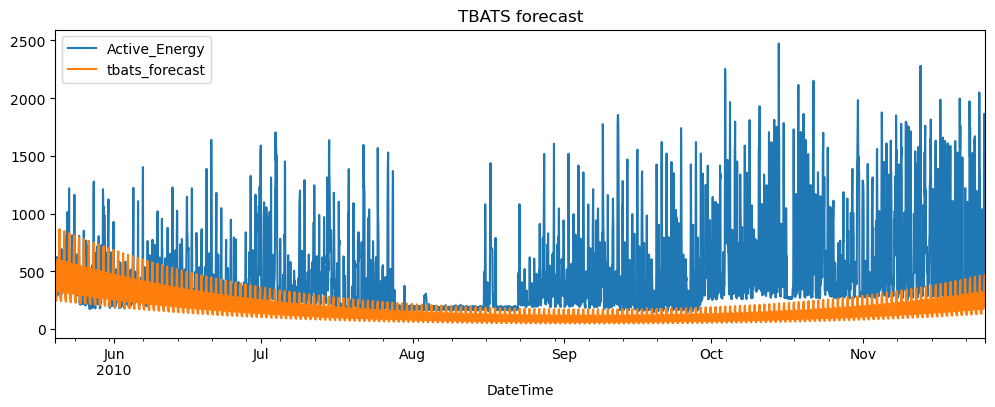

In [38]:
test_df[['Active_Energy','tbats_forecast']].plot(figsize=(12,4))
plt.title('TBATS forecast')
plt.show()

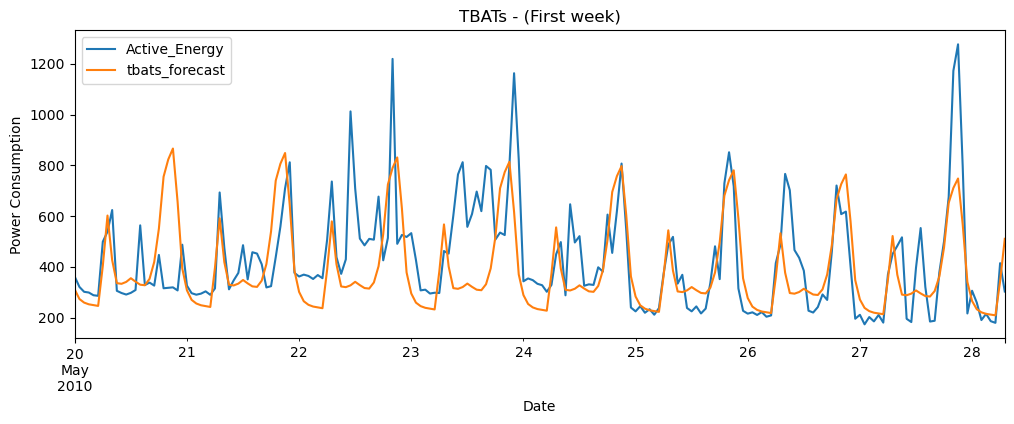

In [39]:
test_df.iloc[:200,[0,3]].plot(figsize=(12,4))

plt.title("TBATs - (First week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

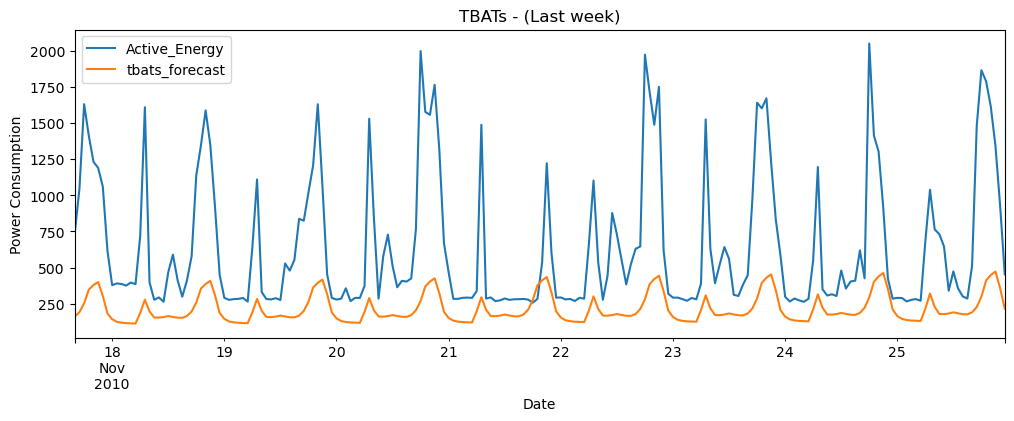

In [40]:
test_df.iloc[-200:,[0,3]].plot(figsize=(12,4))

plt.title("TBATs - (Last week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

In [41]:
rmse_arima = np.sqrt(mean_squared_error(test_df['Active_Energy'], test_df['tbats_forecast']))
r2_arima = r2_score(test_df['Active_Energy'], test_df['tbats_forecast'])
mae_arima = mean_absolute_error(test_df['Active_Energy'], test_df['tbats_forecast'])

print("Root mean Squared Error: ", rmse_arima)
print("R2 Score: ", r2_arima)
print("Mean Absolute Error: ", mae_arima)

Root mean Squared Error:  446.04080549248204
R2 Score:  -0.5806403264750477
Mean Absolute Error:  300.4451461830769


In [85]:
with open('tbats_model1.pkl', 'wb') as f:
    pickle.dump(model, f)

In [65]:
estimator2 = TBATS(seasonal_periods=(24*7, 24*365.25))
model2 = estimator2.fit(train_df['Active_Energy'])

In [66]:
print(model2.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [ 168. 8766.]
Seasonal harmonics [81  1]
ARMA errors (p, q): (3, 4)
Box-Cox Lambda 0.000001
Smoothing (Alpha): 1.055616
Seasonal Parameters (Gamma): [-6.32060817e-05  2.32735855e-05 -1.65932535e-05 -5.30233216e-06]
AR coefficients [-1.65932535e-05 -5.30233216e-06  1.76708920e-01]
MA coefficients [-0.34719622 -0.25753513 -0.31195568 -0.03925225]
Seed vector [ 6.82725227e+00  6.60631953e-02  5.95350206e-02  3.68410114e-02
  4.93732138e-04 -1.90674603e-02 -2.45305491e-02  6.22228180e-02
 -7.36927418e-03 -4.45908798e-03  2.14673959e-02  2.52413077e-02
  3.71614883e-02  4.62446217e-02 -1.74856873e-01  4.45188293e-02
  3.55133362e-02  1.88110827e-02  1.31310129e-02  1.02481730e-02
  2.05316016e-02 -6.41766541e-02  1.75688137e-02  8.06580791e-03
  8.10028224e-03 -1.06379861e-02  8.34895484e-03 -6.57977014e-03
  2.43983035e-03  3.76389022e-03  2.86926381e-04  8.39687364e-03
  1.86718040e-02  1.91449039e-02  2.95591677

In [72]:
# Forecast 365 days ahead
test_df['tbats_forecast2'] = model2.forecast(steps=len(test_df))

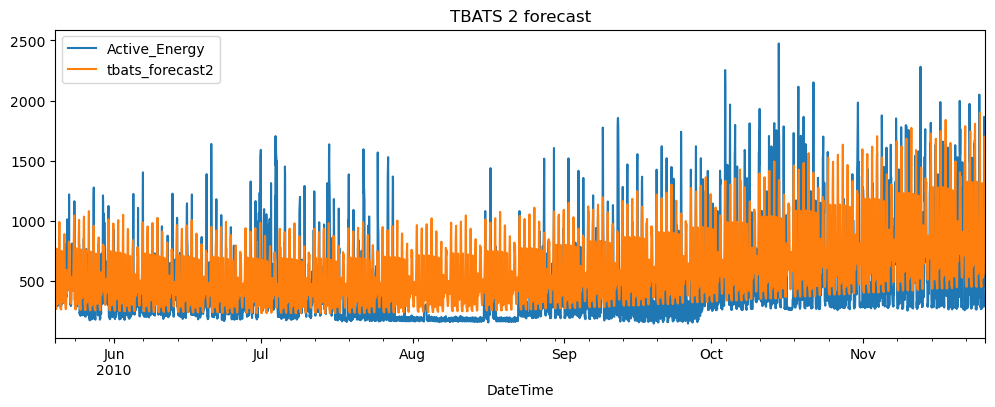

In [73]:
test_df[['Active_Energy','tbats_forecast2']].plot(figsize=(12,4))
plt.title('TBATS 2 forecast')
plt.show()

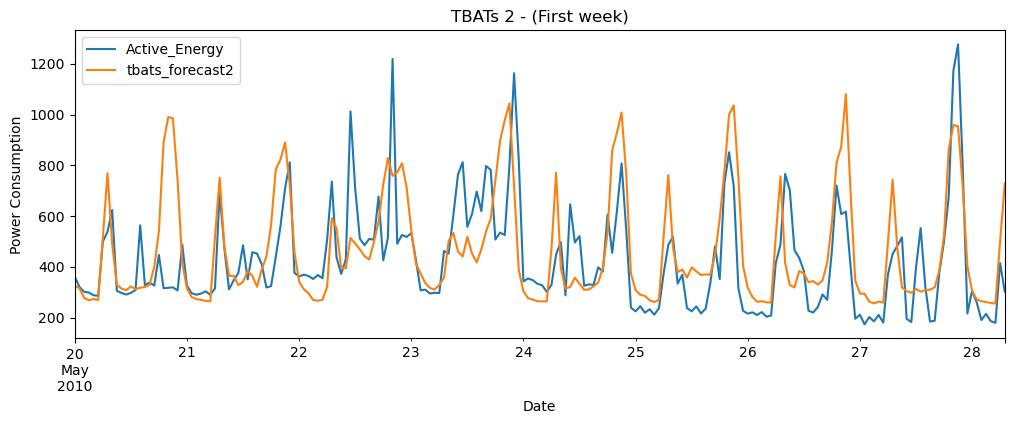

In [74]:
test_df.iloc[:200,[0,6]].plot(figsize=(12,4))

plt.title("TBATs 2 - (First week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

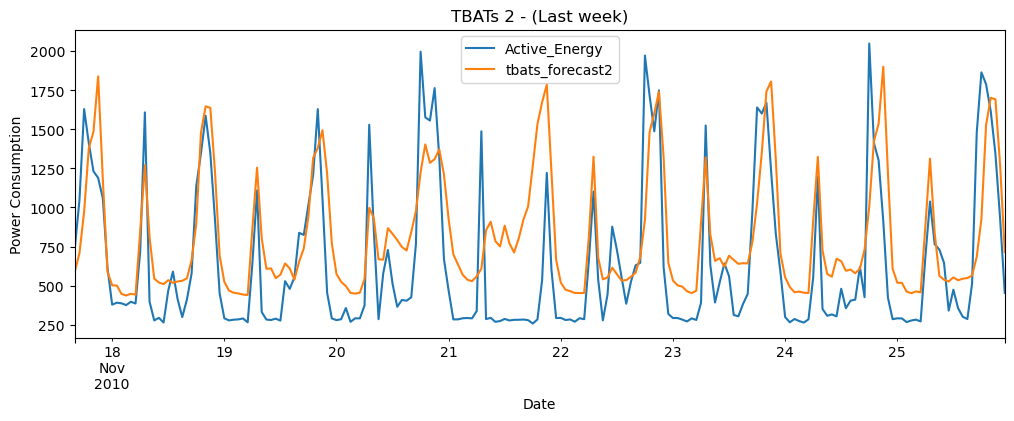

In [75]:
test_df.iloc[-200:,[0,6]].plot(figsize=(12,4))

plt.title("TBATs 2 - (Last week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

In [76]:
rmse_arima = np.sqrt(mean_squared_error(test_df['Active_Energy'], test_df['tbats_forecast2']))
r2_arima = r2_score(test_df['Active_Energy'], test_df['tbats_forecast2'])
mae_arima = mean_absolute_error(test_df['Active_Energy'], test_df['tbats_forecast2'])

print("Root mean Squared Error: ", rmse_arima)
print("R2 Score: ", r2_arima)
print("Mean Absolute Error: ", mae_arima)

Root mean Squared Error:  302.08264944646055
R2 Score:  0.27500428746316785
Mean Absolute Error:  221.4459732753819


In [84]:
with open('tbats_model2.pkl', 'wb') as f:
    pickle.dump(model2, f)

## Prophet

In [42]:
prophet_model = Prophet()

temp = train_df['Active_Energy'].reset_index()
temp.columns = ['ds', 'y']

prophet_model.fit(temp)

00:22:56 - cmdstanpy - INFO - Chain [1] start processing
00:23:04 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
temp_test = pd.DataFrame({'ds': test_df.index})

forecast = prophet_model.predict(temp_test)

test_df['prohpet_forecast'] = forecast.yhat.values

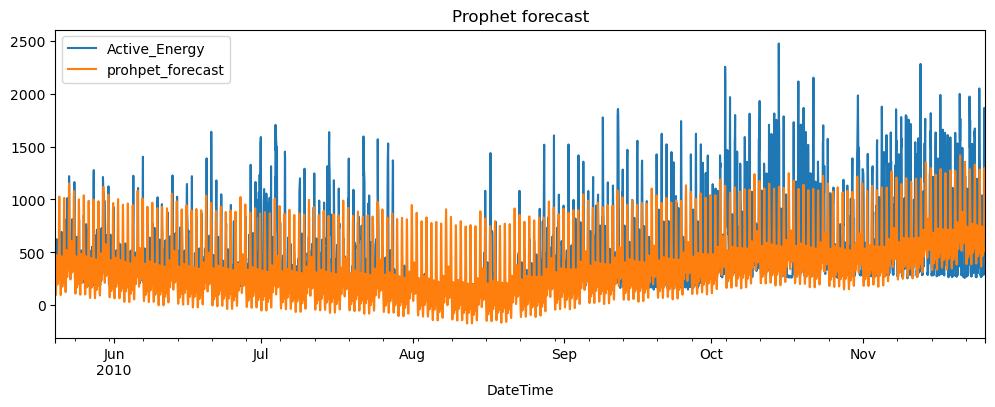

In [44]:
test_df[['Active_Energy','prohpet_forecast']].plot(figsize=(12,4))
plt.title('Prophet forecast')
plt.show()

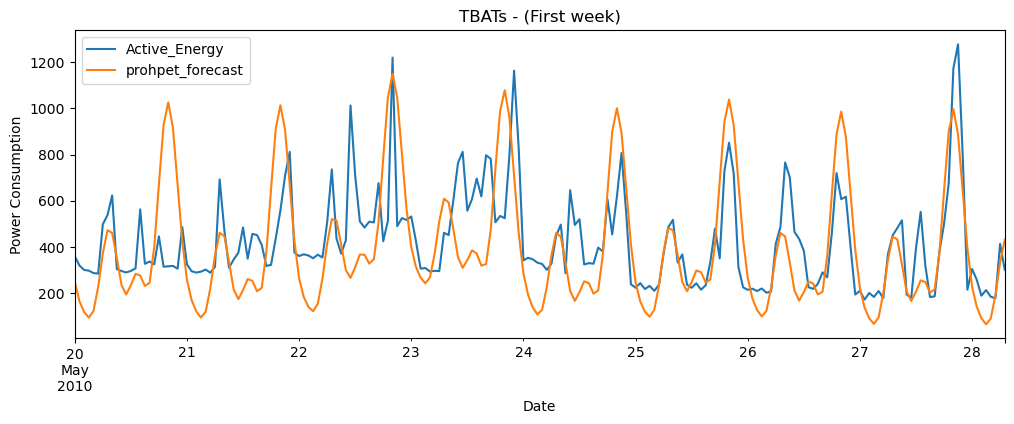

In [45]:
test_df.iloc[:200,[0,4]].plot(figsize=(12,4))

plt.title("Prophet - (First week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

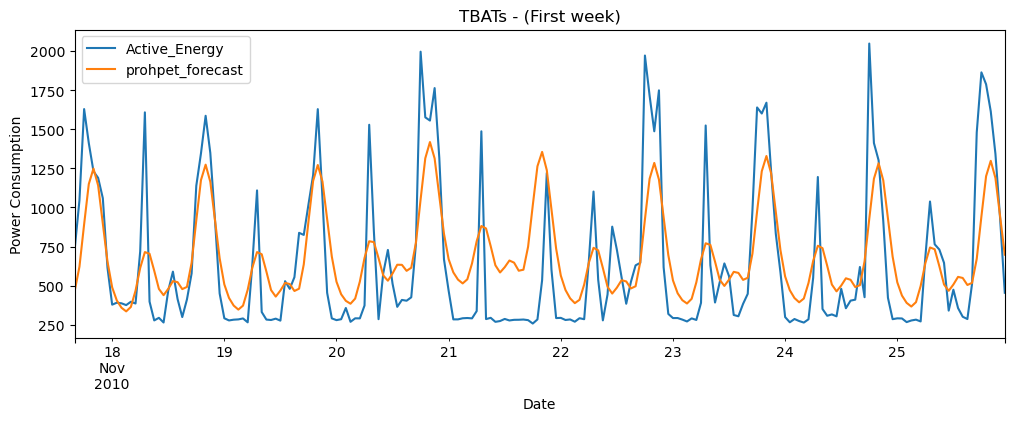

In [46]:
test_df.iloc[-200:,[0,4]].plot(figsize=(12,4))

plt.title("Prophet - (First week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

In [47]:
rmse_arima = np.sqrt(mean_squared_error(test_df['Active_Energy'], test_df['prohpet_forecast']))
r2_arima = r2_score(test_df['Active_Energy'], test_df['prohpet_forecast'])
mae_arima = mean_absolute_error(test_df['Active_Energy'], test_df['prohpet_forecast'])

print("Root mean Squared Error: ", rmse_arima)
print("R2 Score: ", r2_arima)
print("Mean Absolute Error: ", mae_arima)

Root mean Squared Error:  321.1377404804441
R2 Score:  0.18065544928507882
Mean Absolute Error:  228.31129201194696


In [81]:
import pickle

with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)

In [77]:
test_df.to_csv('Results_forecast.csv', index=True)

In [49]:

prophet = Prophet(
     daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)

# Accounting seasonalities for conditional variance 

prophet.add_seasonality(name='yearly', period=365.25, fourier_order=10)
prophet.add_seasonality(name='weekly_spring', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_spring')
prophet.add_seasonality(name='weekly_summer', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_summer')
prophet.add_seasonality(name='weekly_autumn', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_autumn')
prophet.add_seasonality(name='weekly_winter', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_winter')
prophet.add_seasonality(name='daily_spring',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_spring')
prophet.add_seasonality(name='daily_summer',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_summer')
prophet.add_seasonality(name='daily_autumn',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_autumn')
prophet.add_seasonality(name='daily_winter',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_winter')
prophet.add_seasonality(name='daily_weekend',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekend')
prophet.add_seasonality(name='daily_weekday',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekday')

In [51]:
train_prophet = train_df['Active_Energy'].reset_index()
train_prophet.columns = ['ds', 'y']

test_prophet = test_df['Active_Energy'].reset_index()
test_prophet.columns = ['ds', 'y']

In [52]:
# conditions which are defined to make different seasonalities in the time series.

def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name in ('Saturday', 'Sunday')

def month(ds):
    date = pd.to_datetime(ds)
    return (date.month)

train_prophet['month'] = train_prophet['ds'].apply(month)
test_prophet['month'] = test_prophet['ds'].apply(month)

# adding to train set
train_prophet['is_spring'] = train_prophet['ds'].apply(is_spring)
train_prophet['is_summer'] = train_prophet['ds'].apply(is_summer)
train_prophet['is_autumn'] = train_prophet['ds'].apply(is_autumn)
train_prophet['is_winter'] = train_prophet['ds'].apply(is_winter)
train_prophet['is_weekend'] = train_prophet['ds'].apply(is_weekend)
train_prophet['is_weekday'] = ~train_prophet['ds'].apply(is_weekend)

# adding to test set
test_prophet['is_spring'] = test_prophet['ds'].apply(is_spring)
test_prophet['is_summer'] = test_prophet['ds'].apply(is_summer)
test_prophet['is_autumn'] = test_prophet['ds'].apply(is_autumn)
test_prophet['is_winter'] = test_prophet['ds'].apply(is_winter)
test_prophet['is_weekend'] = test_prophet['ds'].apply(is_weekend)
test_prophet['is_weekday'] = ~test_prophet['ds'].apply(is_weekend)

#Month 
test_prophet['jan'] = test_prophet['month']==1
test_prophet['feb'] = test_prophet['month']==2
test_prophet['mar'] = test_prophet['month']==3
test_prophet['apr'] = test_prophet['month']==4
test_prophet['may'] = test_prophet['month']==5
test_prophet['jun'] = test_prophet['month']==6
test_prophet['jul'] = test_prophet['month']==7
test_prophet['aug'] = test_prophet['month']==8
test_prophet['sep'] = test_prophet['month']==9
test_prophet['oct'] = test_prophet['month']==10
test_prophet['nov'] = test_prophet['month']==11
test_prophet['dec'] = test_prophet['month']==12


#Month 
train_prophet['jan'] = train_prophet['month']==1
train_prophet['feb'] = train_prophet['month']==2
train_prophet['mar'] = train_prophet['month']==3
train_prophet['apr'] = train_prophet['month']==4
train_prophet['may'] = train_prophet['month']==5
train_prophet['jun'] = train_prophet['month']==6
train_prophet['jul'] = train_prophet['month']==7
train_prophet['aug'] = train_prophet['month']==8
train_prophet['sep'] = train_prophet['month']==9
train_prophet['oct'] = train_prophet['month']==10
train_prophet['nov'] = train_prophet['month']==11
train_prophet['dec'] = train_prophet['month']==12

In [53]:
prophet.fit(train_prophet)

10:00:59 - cmdstanpy - INFO - Chain [1] start processing
10:01:19 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
test_df['prohpet_forecast2'] = prophet.predict(test_prophet).yhat.values

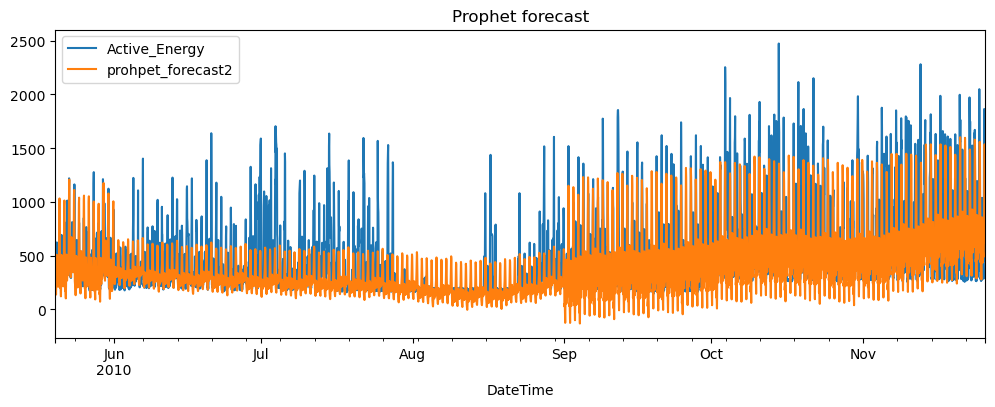

In [58]:
test_df[['Active_Energy','prohpet_forecast2']].plot(figsize=(12,4))
plt.title('Prophet forecast')
plt.show()

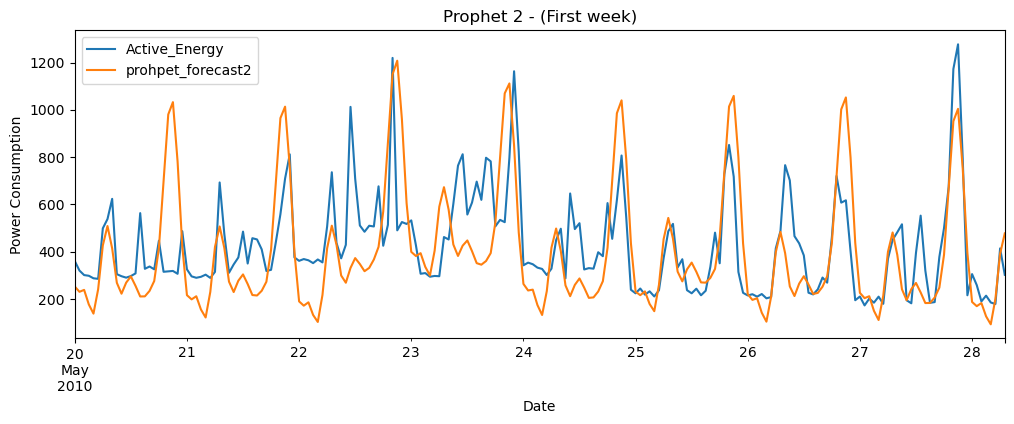

In [61]:
test_df.iloc[:200,[0,5]].plot(figsize=(12,4))

plt.title("Prophet 2 - (First week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

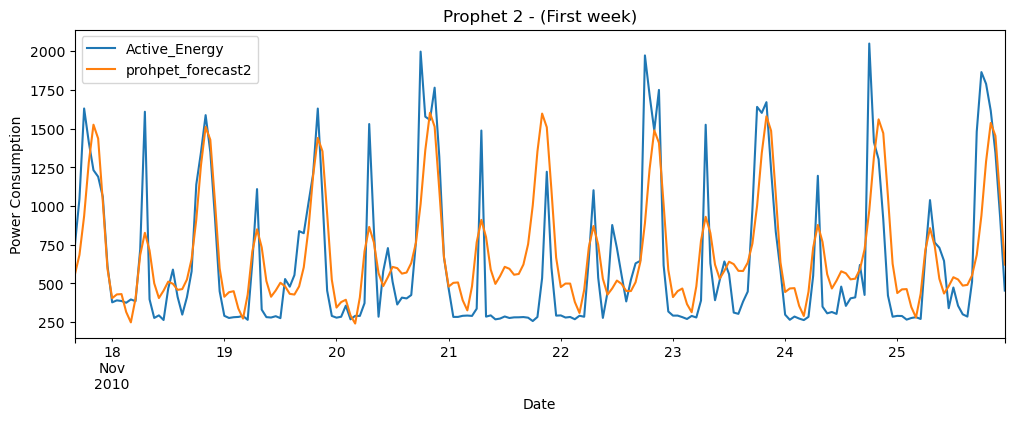

In [62]:
test_df.iloc[-200:,[0,5]].plot(figsize=(12,4))

plt.title("Prophet 2 - (First week)")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend(loc="best")
plt.show()

In [64]:
rmse_arima = np.sqrt(mean_squared_error(test_df['Active_Energy'], test_df['prohpet_forecast2']))
r2_arima = r2_score(test_df['Active_Energy'], test_df['prohpet_forecast2'])
mae_arima = mean_absolute_error(test_df['Active_Energy'], test_df['prohpet_forecast2'])

print("Root mean Squared Error: ", rmse_arima)
print("R2 Score: ", r2_arima)
print("Mean Absolute Error: ", mae_arima)

Root mean Squared Error:  285.22285152715455
R2 Score:  0.35367268585961475
Mean Absolute Error:  183.50187712910824


In [82]:
import pickle

with open('prophet_model2.pkl', 'wb') as f:
    pickle.dump(prophet, f)